In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/Dataset.zip"

Streaming output truncated to the last 5000 lines.
 extracting: Dataset/Closed_eyes/s0037_02817_1_0_0_0_0_01.png  
 extracting: Dataset/Closed_eyes/s0037_02818_1_0_0_0_0_01.png  
 extracting: Dataset/Closed_eyes/s0037_02819_1_0_0_0_0_01.png  
 extracting: Dataset/Closed_eyes/s0037_02820_1_0_0_0_0_01.png  
 extracting: Dataset/Closed_eyes/s0037_02821_1_0_0_0_0_01.png  
 extracting: Dataset/Closed_eyes/s0037_02822_1_0_0_0_0_01.png  
 extracting: Dataset/Closed_eyes/s0037_02823_1_0_0_0_0_01.png  
 extracting: Dataset/Closed_eyes/s0037_02824_1_0_0_0_1_01.png  
 extracting: Dataset/Closed_eyes/s0037_02825_1_0_0_0_0_01.png  
 extracting: Dataset/Closed_eyes/s0037_02826_1_0_0_0_1_01.png  
 extracting: Dataset/Closed_eyes/s0037_02827_1_0_0_0_0_01.png  
 extracting: Dataset/Closed_eyes/s0037_02828_1_0_0_0_1_01.png  
 extracting: Dataset/Closed_eyes/s0037_02829_1_0_0_0_0_01.png  
 extracting: Dataset/Closed_eyes/s0037_02830_1_0_0_0_1_01.png  
 extracting: Dataset/Closed_eyes/s0037_02831_1_0_0_0_

In [ ]:
import tensorflow as tf
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import keras
from tqdm import tqdm
from random import shuffle
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Flatten, Dropout, ZeroPadding3D
from keras.layers.recurrent import LSTM
from keras.models import Sequential, load_model
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import TimeDistributed
from keras.layers.convolutional import (Conv2D, MaxPooling3D, Conv3D, MaxPooling2D)

In [ ]:
print(keras.__version__)
print(tf.__version__)

2.4.3
2.4.1


In [ ]:
img_array = cv2.imread("/content/Dataset/Closed_eyes/s0001_00004_0_0_0_0_0_01.png",cv2.IMREAD_GRAYSCALE)

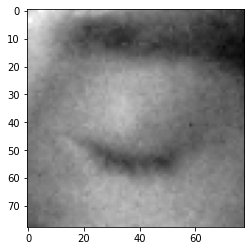

In [ ]:
plt.imshow(img_array,cmap="gray")

In [ ]:
img_array.shape

(78, 78)

In [ ]:
open_eyes = "/content/Dataset/opened_eyes"
close_eyes = "/content/Dataset/Closed_eyes"

In [ ]:
def load_dataset(image_dir, image_size):
  if image_dir == open_eyes:
    o_eyes = []
    for img in tqdm(os.listdir(open_eyes)):
        label = 1.0                                                 
        path = os.path.join(open_eyes,img)
        img = cv2.imread(path)
        if img is not None:
          img = cv2.resize(img, (image_size, image_size))
          o_eyes.append([np.array(img),label])
    shuffle(o_eyes)
    return o_eyes

  elif image_dir == close_eyes:
    c_eyes = []
    for img in tqdm(os.listdir(close_eyes)):
        label = 0.0                                                
        path = os.path.join(close_eyes,img)
        img = cv2.imread(path)
        if img is not None:
          img = cv2.resize(img, (image_size, image_size))
          c_eyes.append([np.array(img),label])
    shuffle(c_eyes)
    return c_eyes

In [ ]:
open_eyes = load_dataset(open_eyes,224)
close_eyes = load_dataset(close_eyes,224)

100%|██████████| 4000/4000 [00:01<00:00, 2681.70it/s]


In [ ]:
X_open = np.array([i[0] for i in open_eyes]).reshape(-1,224,224,3)
y_open = np.array([i[1] for i in open_eyes])
X_close = np.array([i[0] for i in close_eyes]).reshape(-1,224,224,3)
y_close = np.array([i[1] for i in close_eyes])
X = np.concatenate((X_open, X_close))
y = np.concatenate((y_open, y_close)) 

In [ ]:
classes = ['Closed_Eyes', 'Open_Eyes']

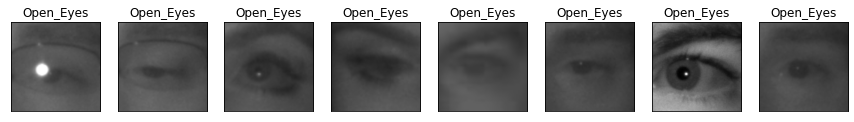

In [ ]:
fig = plt.figure(figsize=(15,15))
for i in range(8):
  ax = fig.add_subplot(1,8,i+1, xticks=[], yticks=[])
  ax.imshow(X[i])
  if y[i]==1.0:
    ax.set_title(classes[1])
  else:
    ax.set_title(classes[0])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, shuffle = True, random_state = 7)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.50, shuffle = True, random_state = 7)

In [ ]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(5600, 224, 224, 3)
(1200, 224, 224, 3)
(1200, 224, 224, 3)
(5600,)
(1200,)
(1200,)


In [ ]:
X_train = X_train.astype('float32')
tr_datagen = ImageDataGenerator(rescale=1./255)

X_validation = X_val.astype('float32')
val_datagen = ImageDataGenerator(rescale=1./255)

X_test = X_test.astype('float32')
te_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_dynamo = tr_datagen.flow(X_train, y_train, batch_size = 32)
val_dynamo = val_datagen.flow(X_val, y_val, batch_size = 32)
test_dynamo = te_datagen.flow(X_test, y_test, batch_size = 32)

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from keras.optimizers import Adam

In [ ]:
model = tf.keras.applications.mobilenet.MobileNet()

17227776/17225924 [==============================] - 0s 0us/step


In [ ]:
base_input = model.layers[0].input

In [ ]:
base_output = model.layers[-4].output

In [ ]:
Flat_layer = layers.Flatten()(base_output)
final_output = layers.Dense(1)(Flat_layer)
final_output = layers.Activation('sigmoid')(final_output)

In [ ]:
new_model = keras.Model(inputs = base_input, outputs = final_output)

In [ ]:
new_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0     

In [ ]:
new_model.compile(optimizer= 'adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history = new_model.fit(train_dynamo, epochs=2, validation_data= val_dynamo, verbose = 1)

Epoch 1/2
175/175 [==============================] - 82s 281ms/step - loss: 0.1896 - accuracy: 0.9318 - val_loss: 0.0725 - val_accuracy: 0.9750
Epoch 2/2
175/175 [==============================] - 47s 269ms/step - loss: 0.0234 - accuracy: 0.9919 - val_loss: 0.0192 - val_accuracy: 0.9900


In [ ]:
new_model.save('mobile_net.h5')
new_model = load_model('mobile_net.h5')

In [ ]:
score = new_model.evaluate_generator(test_dynamo, steps = len(X_test))
print('Test loss',score[0])
print('Test Accuracy',score[1])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Test loss 0.01690841093659401
Test Accuracy 0.9958333373069763
